In [129]:
import pandas as pd

In [71]:
# Загружаем данные о покупках из csv файла и записываем их в pandas data frame под названием df
file = 'orders.csv'
df = pd.read_csv(f'{file}')
df.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [72]:
# Узнаем чуть больше о датасете:
# - какая в нем содержится информация
df.columns

Index(['id', 'order_date', 'ship_mode', 'customer_id', 'sales'], dtype='object')

In [38]:
df.dtypes

id                      int64
order_date     datetime64[ns]
ship_mode              object
customer_id            object
sales                 float64
dtype: object

In [78]:
df.sales.describe()

count     5009.000000
mean       458.614666
std        954.730953
min          0.556000
25%         37.630000
50%        151.960000
75%        512.064000
max      23661.228000
Name: sales, dtype: float64

In [79]:
# - время, в течении которого собирались данные
df.order_date = pd.to_datetime(df.order_date)
f'{str(df.order_date.min())} - {str(df.order_date.max())}'

'2014-01-03 00:00:00 - 2017-12-30 00:00:00'

С датасетом orders.csv нам доступно 4 года данных.

In [48]:
# Чистка данных
df=df[(df.customer_id.notnull()) & (df.sales!=0)]

In [191]:
# Для анализа нам понадобятся 3 переменные: 1) id клиента, 2) id покупки и 3) время совершения покупки. 
df = df[['customer_id', 'id', 'order_date']].drop_duplicates()

,customer_id,id,order_date
0,DK-13375,100006,2014-09-07
1,EB-13705,100090,2014-07-08
2,NF-18475,100293,2014-03-14
3,JC-15340,100328,2014-01-28
4,JM-15655,100363,2014-04-08
...,...,...,...
5004,JO-15145,168802,2017-11-03
5005,LH-16900,169320,2017-07-23
5006,AA-10375,169488,2017-09-07
5007,MG-17650,169502,2017-08-28


In [192]:
# Посмотрим частоту совершения покупок в нашем Интернет-магазине для рандомно выбранных клиентов
id = df.sample().customer_id.str.cat()
df[df.customer_id == id]

,customer_id,id,order_date
227,MG-17890,118276,2014-12-29
1424,MG-17890,146948,2015-07-16
2534,MG-17890,154053,2016-03-04
2702,MG-17890,163972,2016-10-17
2869,MG-17890,102967,2017-09-22
3212,MG-17890,121125,2017-05-30
3362,MG-17890,127712,2017-08-31
3535,MG-17890,136672,2017-03-07
4133,MG-17890,166933,2017-04-24


In [195]:
average_nmb_orders = df.groupby('customer_id').order_date.count().mean()
f'Среднее количество раз, которое клиент совершает покупку за год равно {average_nmb_orders / 4}'

'Среднее количество раз, которое клиент совершает покупку за год равно 1.5791298865069356'

Средняя частота совершения покупок в нашем Интернет-магазине довольно низкая: в среднем примерно один-два раза в год клиенты пользуются нашим магазином. 
Чтобы посчитать retention для такого низкочастотного сервиса, расчитаем процент покупателей, которые совершают повторные покупки каждый 
последующий год. 

Распределим покупателей по временным когортам - для такого низкочастотного сервиса можно использовать либо квартальные, либо годовые когорты (так как у нас нет информации о дате регистрации клиентов, предполагаем, что первое появление покупателя в датасете
и есть его первая покупка в Интернет-магазине)

In [213]:
# Начнем с годовых когорт
cohort_frequency = 'Y'
df['order_year'] = df['order_date'].dt.to_period(cohort_frequency)
df['cohort'] = df.groupby('customer_id')['order_date'] \
                 .transform('min') \
                 .dt.to_period(cohort_frequency)
df

,customer_id,id,order_date,order_year,cohort
0,DK-13375,100006,2014-09-07,2014,2014
1,EB-13705,100090,2014-07-08,2014,2014
2,NF-18475,100293,2014-03-14,2014,2014
3,JC-15340,100328,2014-01-28,2014,2014
4,JM-15655,100363,2014-04-08,2014,2014
...,...,...,...,...,...
5004,JO-15145,168802,2017-11-03,2017,2014
5005,LH-16900,169320,2017-07-23,2017,2014
5006,AA-10375,169488,2017-09-07,2017,2014
5007,MG-17650,169502,2017-08-28,2017,2014


In [211]:
from operator import attrgetter
df_cohort = df.groupby(['cohort', 'order_year']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_year - df_cohort.cohort).apply(attrgetter('n'))
df_cohort

,cohort,order_year,n_customers,period_number
0,2014,2014,595,0
1,2014,2015,437,1
2,2014,2016,485,2
3,2014,2017,517,3
4,2015,2015,136,0
5,2015,2016,102,1
6,2015,2017,120,2
7,2016,2016,51,0
8,2016,2017,45,1
9,2017,2017,11,0


In [202]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [203]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

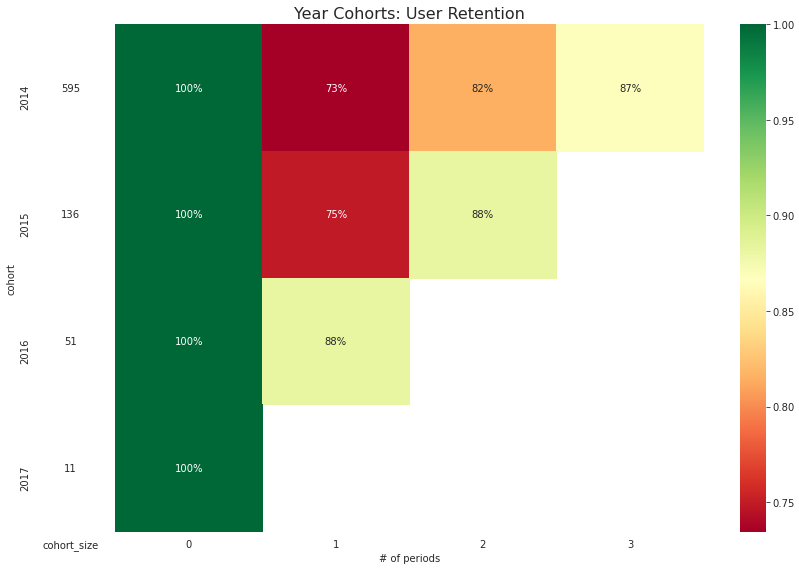

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Year Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

2017 год был очень удачным в плане удержания клиентов - вернулись многие покупатели, которые не пользовались Интернет-магазином с 2014 и с 2015 года.
Однако стоит заметить, что привлечение новых клиентов заметно ухудшалось в течении данных 4 лет.

In [214]:
# Рассмотрим квартальные когорты
cohort_frequency = 'Q'
df['order_quarter'] = df['order_date'].dt.to_period(cohort_frequency)
df['cohort'] = df.groupby('customer_id')['order_date'] \
                 .transform('min') \
                 .dt.to_period(cohort_frequency)
df

,customer_id,id,order_date,order_year,cohort,order_quarter
0,DK-13375,100006,2014-09-07,2014,2014Q3,2014Q3
1,EB-13705,100090,2014-07-08,2014,2014Q3,2014Q3
2,NF-18475,100293,2014-03-14,2014,2014Q1,2014Q1
3,JC-15340,100328,2014-01-28,2014,2014Q1,2014Q1
4,JM-15655,100363,2014-04-08,2014,2014Q2,2014Q2
...,...,...,...,...,...,...
5004,JO-15145,168802,2017-11-03,2017,2014Q1,2017Q4
5005,LH-16900,169320,2017-07-23,2017,2014Q3,2017Q3
5006,AA-10375,169488,2017-09-07,2017,2014Q2,2017Q3
5007,MG-17650,169502,2017-08-28,2017,2014Q3,2017Q3


In [217]:
from operator import attrgetter
df_cohort = df.groupby(['cohort', 'order_quarter']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_quarter - df_cohort.cohort).apply(attrgetter('n'))
df_cohort

,cohort,order_quarter,n_customers,period_number
0,2014Q1,2014Q1,121,0
1,2014Q1,2014Q2,20,1
2,2014Q1,2014Q3,28,2
3,2014Q1,2014Q4,41,3
4,2014Q1,2015Q1,18,4
...,...,...,...,...
129,2017Q2,2017Q2,2,0
130,2017Q2,2017Q4,1,2
131,2017Q3,2017Q3,3,0
132,2017Q3,2017Q4,1,1


In [218]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

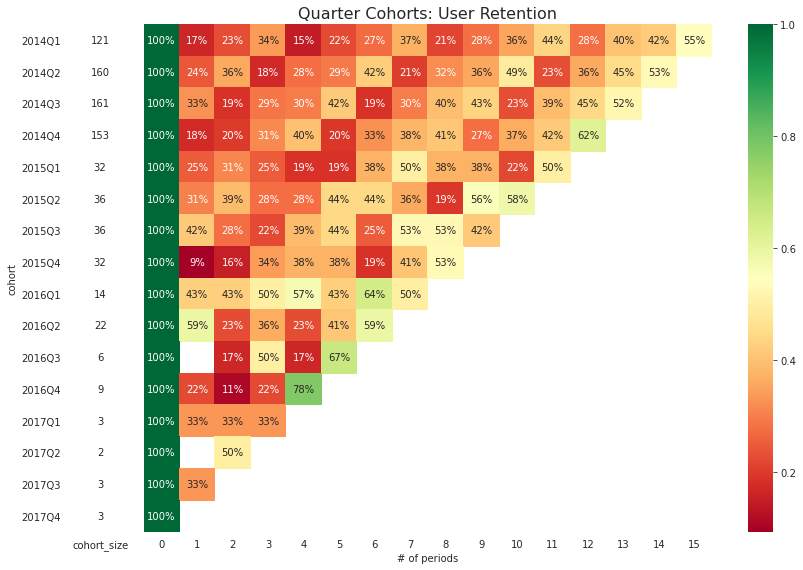

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Quarter Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Что-то случилось в 2017 году, особенно в 4 квартале, что заставило многих клиентов вернуться за покупками в Интернет-магазин. Так-же бросается в глаза когорта 1 квартала 2016 года: пришли активные пользователи с высоким коэффициентом удержания.
Гипотеза руководителя не находит подтверждения в когортномм анализе retention rate. 